The general goal of this notebook is to develop pre-processing scripts that aim to predict percentiles of the outputs's unconditional PDF rather than physical values.

# Imports

In [15]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

In [16]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [17]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Load training set in memory

## Load data

In [18]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [19]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [20]:
path_TRAIN = path_data + '2021_01_24_O3_TRAIN_shuffle.nc'

In [7]:
path_TRAIN

'/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2021_01_24_O3_TRAIN_shuffle.nc'

In [7]:
train_data = xr.open_dataset(path_TRAIN)

In [8]:
train_data

<xarray.Dataset>
Dimensions:    (sample: 47177728, var_names: 214)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
Dimensions without coordinates: sample
Data variables:
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
    vars       (sample, var_names) float64 ...

In [9]:
train_data['var_names']

<xarray.DataArray 'var_names' (var_names: 214)>
array(['QBP', 'QBP', 'QBP', ..., 'QRS', 'QRS', 'QRS'], dtype=object)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'

In [11]:
train_data['vars'].shape

(47177728, 214)

In [18]:
train_data['var_names'][-120:]

<xarray.DataArray 'var_names' (var_names: 120)>
array(['PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS',
       'QRS', 'QRS

## Create histogram bins based on max,min

In [20]:
train_data_max = train_data['vars'].max(axis=0)

In [21]:
train_data_min = train_data['vars'].min(axis=0)

In [49]:
train_data_max[-121]

<xarray.DataArray 'vars' ()>
array(992.12207)
Coordinates:
    var_names  <U5 'LHFLX'

In [50]:
train_data_min[-121]

<xarray.DataArray 'vars' ()>
array(-106.082199)
Coordinates:
    var_names  <U5 'LHFLX'

In [51]:
train_data_max.shape

(214,)

In [52]:
214-121

93

In [53]:
train_data_max[94]

<xarray.DataArray 'vars' ()>
array(0.)
Coordinates:
    var_names  <U3 'PHQ'

In [54]:
train_data_max[93]

<xarray.DataArray 'vars' ()>
array(992.12207)
Coordinates:
    var_names  <U5 'LHFLX'

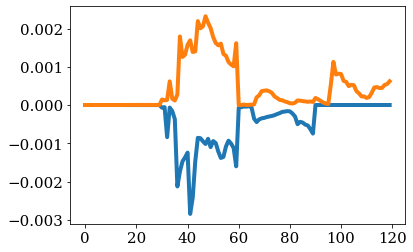

In [24]:
plt.plot(train_data_min[-120:])
plt.plot(train_data_max[-120:])

In [25]:
train_data_bins = np.linspace(start=train_data_min,stop=train_data_max,num=1000)

In [26]:
train_data_bins.shape

(1000, 214)

In [40]:
train_data_min[-91]

<xarray.DataArray 'vars' ()>
array(-2.703581e-06)
Coordinates:
    var_names  <U3 'PHQ'

In [42]:
train_data_max[-91]

<xarray.DataArray 'vars' ()>
array(1.331972e-06)
Coordinates:
    var_names  <U3 'PHQ'

array([-2.70358146e-06, -2.69954187e-06, -2.69550227e-06, -2.69146268e-06,
       -2.68742309e-06, -2.68338349e-06, -2.67934390e-06, -2.67530431e-06,
       -2.67126471e-06, -2.66722512e-06, -2.66318553e-06, -2.65914593e-06,
       -2.65510634e-06, -2.65106675e-06, -2.64702715e-06, -2.64298756e-06,
       -2.63894797e-06, -2.63490837e-06, -2.63086878e-06, -2.62682919e-06,
       -2.62278959e-06, -2.61875000e-06, -2.61471041e-06, -2.61067081e-06,
       -2.60663122e-06, -2.60259163e-06, -2.59855203e-06, -2.59451244e-06,
       -2.59047285e-06, -2.58643326e-06, -2.58239366e-06, -2.57835407e-06,
       -2.57431448e-06, -2.57027488e-06, -2.56623529e-06, -2.56219570e-06,
       -2.55815610e-06, -2.55411651e-06, -2.55007692e-06, -2.54603732e-06,
       -2.54199773e-06, -2.53795814e-06, -2.53391854e-06, -2.52987895e-06,
       -2.52583936e-06, -2.52179976e-06, -2.51776017e-06, -2.51372058e-06,
       -2.50968098e-06, -2.50564139e-06, -2.50160180e-06, -2.49756220e-06,
       -2.49352261e-06, -

## Calculate quantile for each output variable

In [72]:
train_data['vars'][:,-91].quantile(np.array([0,1])).values

array([-2.70358146e-06,  1.33197216e-06])

In [21]:
quantile_array = np.linspace(0,1,1001)

In [22]:
PERC_array = np.zeros((1001,184))

In [74]:
for ivar in range(214):
    print('ivar=',ivar,'           ',end='\r')
    PERC_array[:,ivar] = train_data['vars'][:,ivar].quantile(quantile_array).values

In [75]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

hf = open(pathPKL+'2021_01_24_O3_TRAIN_shuffle'+'_PERC.pkl','wb')

F_data = {'quantile_array':quantile_array,'PERC_array':PERC_array}

pickle.dump(F_data,hf)
hf.close()

In [76]:
F_data

{'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
 'PERC_array': array([[9.94927973e-07, 9.68830705e-07, 4.62277796e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.99745453e-07, 9.85569386e-07, 5.24233599e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00150617e-06, 9.87641442e-07, 5.24234395e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.77804845e-06, 1.73643605e-06, 1.46164996e-06, ...,
         4.32690976e-05, 4.00223369e-05, 3.74600383e-05],
        [1.78130600e-06, 1.74002975e-06, 1.46422724e-06, ...,
         6.53455651e-05, 7.07500345e-05, 9.00195526e-05],
        [1.79556821e-06, 1.75865364e-06, 1.48329934e-06, ...,
         5.22865215e-04, 5.47407486e-04, 6.19579223e-04]])}

In [79]:
F_data['PERC_array'][:,-91]

array([-2.70358146e-06, -5.69551777e-07, -4.80656313e-07, ...,
        4.20529032e-07,  4.78835986e-07,  1.33197216e-06])

## Repeat for every dataset

In [23]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [24]:
quantile_array = np.linspace(0,1,1001)

In [31]:
path_array = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_04_18_RG_VALID_M4K.nc',
    '2021_04_18_RG_TEST_M4K.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    '2021_04_18_RG_VALID_P4K.nc',
    '2021_04_18_RG_TEST_P4K.nc'
]

In [32]:
#path_array = [
#     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
#     '2021_03_18_O3_VALID_M4K.nc',
#     '2021_03_18_O3_TEST_P4K.nc',
#     '2021_01_24_O3_TRAIN_shuffle.nc',
#     '2021_03_18_O3_TEST_M4K.nc',
#     '2021_01_24_O3_VALID.nc',
#     '2021_01_24_O3_TEST.nc',
#     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
#    '2021_03_18_O3_VALID_P4K.nc'
#]

In [33]:
Ninput = 184

In [34]:
Ninput

184

In [35]:
path_array

['2021_04_18_RG_TRAIN_M4K_shuffle.nc',
 '2021_04_18_RG_VALID_M4K.nc',
 '2021_04_18_RG_TEST_M4K.nc',
 '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
 '2021_04_18_RG_VALID_P4K.nc',
 '2021_04_18_RG_TEST_P4K.nc']

In [36]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data = xr.open_dataset(path_var)
    
    PERC_array = np.zeros((1001,Ninput))
    
    for ivar in range(Ninput):
        print('ivar=',ivar,'           ',end='\r')
        PERC_array[:,ivar] = train_data['vars'][:,ivar].quantile(quantile_array).values
    
    hf = open(pathPKL+'/'+path+'_PERC.pkl','wb')

    F_data = {'quantile_array':quantile_array,'PERC_array':PERC_array}

    pickle.dump(F_data,hf)
    hf.close()
    print('\n')

ipath= 0 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc      
ivar= 183            

ipath= 1 path= 2021_04_18_RG_VALID_M4K.nc      
ivar= 183            

ipath= 2 path= 2021_04_18_RG_TEST_M4K.nc      
ivar= 183            

ipath= 3 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc      
ivar= 183            

ipath= 4 path= 2021_04_18_RG_VALID_P4K.nc      
ivar= 183            

ipath= 5 path= 2021_04_18_RG_TEST_P4K.nc      
ivar= 183            



# Test interpolation onto percentile array

Directly test in preprocessing mode to facilitate duplication of training/validation/test in percentile space

## Testing different interpolation functions

### Imports

In [13]:
pathPKL_train = pathPKL + '/PKL_DATA2021_03_18_O3_TRAIN_M4K_shuffle.nc_PERC.pkl'
pathPKL_test = pathPKL + '/PKL_DATA2021_03_18_O3_TEST_P4K.nc_PERC.pkl'

In [25]:
hf = open(pathPKL_train,'rb')
tmp = pickle.load(hf)
PERC_array = tmp['PERC_array']
quantile_array = tmp['quantile_array']

In [15]:
PERC_array.shape

(1001, 214)

### Load small data

In [20]:
path_dm4K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
ds = xr.open_mfdataset(path_dm4K+'0001-01-05-00000.nc',\
                          decode_times=False)

In [21]:
var0 = ds['PHQ'][1:]

In [57]:
import numpy as np
from scipy.interpolate import interp1d
import scipy

class scipy.interpolate.interp1d(x, y, kind='linear', axis=- 1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)[source]

In [40]:
var_interp = interp1d(x=PERC_array[:,-91],y=quantile_array)

In [41]:
scale_dict = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [42]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

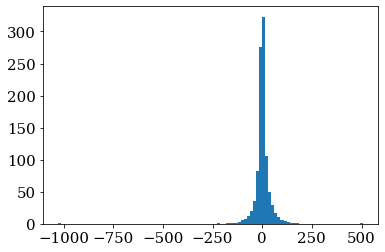

In [43]:
plt.hist(scale_dict['PHQ'][-1]*PERC_array[:,-91],bins=100);

In [44]:
var0.shape

(47, 30, 64, 128)

In [45]:
var0_afterinterp = var_interp(var0[:,-1,:,:])

In [47]:
var0_afterinterp.shape

(47, 64, 128)

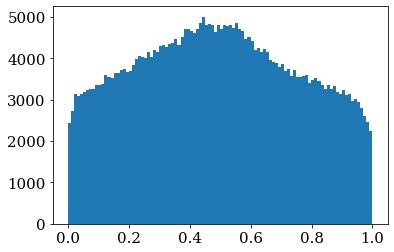

In [50]:
plt.hist(var0_afterinterp.flatten(),bins=100);

In [51]:
path_dm4K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
ds = xr.open_mfdataset(path_dm4K+'0001-03-22-00000.nc',\
                          decode_times=False)

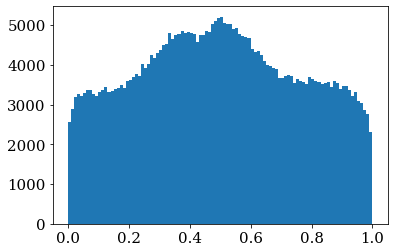

In [52]:
plt.hist((var_interp(ds['PHQ'][:,-1,:,:])).flatten(),bins=100);

In [60]:
var_interp = interp1d(x=PERC_array[:,-1],y=quantile_array,fill_value=(0,1))

In [64]:
var_interp._extrapolate='True'

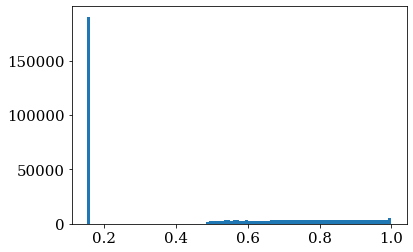

In [65]:
plt.hist((var_interp(ds['QRS'][:,-1,:,:])).flatten(),bins=100);

In [66]:
var_interp = interp1d(x=PERC_array[:,-31],y=quantile_array,fill_value=(0,1))

plt.hist((var_interp(ds['QRL'][:,-1,:,:])).flatten(),bins=100);

## Check with original dataset

In [8]:
path_array = [
#    '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
#    '2021_03_18_O3_VALID_M4K.nc',
    '2021_03_18_O3_TEST_P4K.nc',
#    '2021_01_24_O3_TRAIN_shuffle.nc',
#    '2021_03_18_O3_TEST_M4K.nc',
#    '2021_01_24_O3_VALID.nc',
#    '2021_01_24_O3_TEST.nc',
#    '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
#    '2021_03_18_O3_VALID_P4K.nc'
]

In [10]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data = xr.open_dataset(path_var)
    
    hf = open(pathPKL+'/'+path+'_PERC.pkl','rb')
    tmp = pickle.load(hf)
    
    PERC_array = tmp['PERC_array']
    quantile_array = tmp['quantile_array']

ipath= 0 path= 2021_03_18_O3_TEST_P4K.nc      


In [12]:
import numpy as np
from scipy.interpolate import interp1d
import scipy

In [13]:
interp_fx = interp1d(x=PERC_array[:,-91],y=quantile_array)

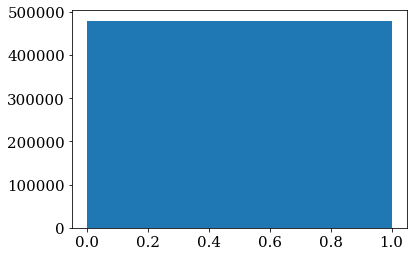

In [14]:
plt.hist((interp_fx(train_data['vars'][:,-91])).flatten(),bins=100);

## Develop preprocessing routine for convert_dataset_20191113

TODO = Test
def compute_perc(ds, var, PERC_array, quantile_array):
    
    from scipy.interpolate import interp1d
    
    # Load variable from dataset
    var0 = ds[var[:-4]][1:]
    # Manually entering ranges for each variable: 
    # This should change and PERC_array should be a dictionary with varianble names
    i0 = {}
    i0['PHQ'] = 94
    i0['TPHYSTND'] = 124
    i0['QRL'] = 154
    i0['QRS'] = 184
    
    # Project onto 1D percentile space to form the output
    output_percentile = 0*var0**0 # Initialization
    for ilev in range(var0.shape[1]):
        print('Interpolating level ',ilev,'out of ',var0.shape[1])
        interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev,:,:],y=quantile_array)
        output_percentile[:,ilev,:,:] = interp_fx(var0[:,ilev,:,:])
        
    return output_percentile

Load dataset

In [32]:
path_PERC = pathPKL+'/'+'2021_03_18_O3_TRAIN_M4K_shuffle.nc'+'_PERC.pkl'

In [33]:
path_PERC

'/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2021_03_18_O3_TRAIN_M4K_shuffle.nc_PERC.pkl'

In [34]:
import pickle
hf = open(path_PERC,'rb')
tmp = pickle.load(hf)
PERC_array = tmp['PERC_array']
quantile_array = tmp['quantile_array']

In [17]:
path_m4K_file = '/DFS-L/DATA/pritchard/tbeucler/SPCAM//sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.00'

In [18]:
datam4K = xr.open_mfdataset(path_m4K_file+'01-06-1*-00000.nc')

In [125]:
var = 'QRLPERC'
ds = datam4K

In [126]:
var0 = ds[var[:-4]][1:]

In [127]:
var0

<xarray.DataArray 'QRL' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float32, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59
Attributes:
    units:      K/s
    long_name:  Longwave heating rate

In [24]:
i0 = {}
i0['PHQ'] = 94
i0['TPHYSTND'] = 124
i0['QRL'] = 154
i0['QRS'] = 184

In [25]:
output_percentile = 0*var0**0 # Initialization

In [36]:
S = var0.shape[1]

In [37]:
S

30

In [79]:
ilev = 29

In [80]:
interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev],y=quantile_array)

In [81]:
interp_fx

In [82]:
var0

<xarray.DataArray 'PHQ' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float32, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59
Attributes:
    units:      kg/kg/s
    long_name:  Specific humidity physics tendency

In [83]:
var0.shape

(479, 30, 64, 128)

In [84]:
var0[:,ilev,:,:].shape

(479, 64, 128)

In [85]:
var0_interp = interp_fx(var0[:,ilev,:,:])

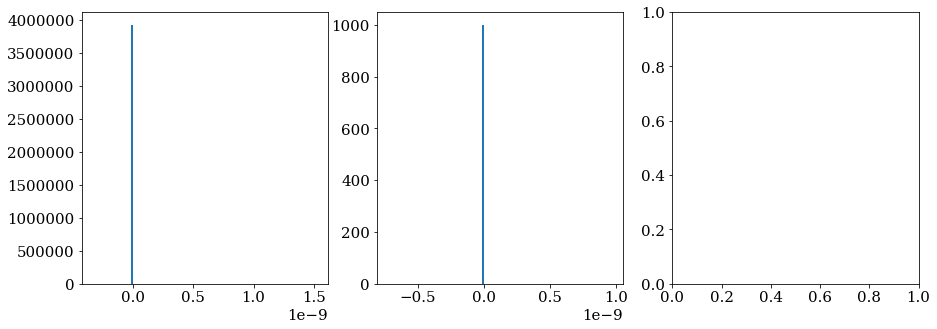

In [92]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(var0[:,ilev,:,:].values.flatten(),bins=100);
ax[1].hist(PERC_array[:,i0[var[:-4]]+ilev],bins=100);
#ax[2].hist(var0_interp.flatten(),bins=100);

In [74]:
PERC_array[:,i0[var[:-4]]+ilev]

array([-2.81775812e-07, -7.93939854e-08, -6.59038065e-08, ...,
        1.14236935e-08,  1.62509410e-08,  2.25147929e-07])

In [88]:
var0.shape

(479, 30, 64, 128)

In [128]:
# Project onto 1D percentile space to form the output
output_percentile = np.zeros(var0.shape) # Initialization
for ilev in range(var0.shape[1]):
    print('Interpolating level ',ilev,'out of ',var0.shape[1])
    interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev],y=quantile_array,bounds_error=False)
    output_percentile[:,ilev,:,:] = interp_fx(var0[:,ilev,:,:].values)

Interpolating level  0 out of  30
Interpolating level  1 out of  30
Interpolating level  2 out of  30
Interpolating level  3 out of  30
Interpolating level  4 out of  30
Interpolating level  5 out of  30
Interpolating level  6 out of  30
Interpolating level  7 out of  30
Interpolating level  8 out of  30
Interpolating level  9 out of  30
Interpolating level  10 out of  30
Interpolating level  11 out of  30
Interpolating level  12 out of  30
Interpolating level  13 out of  30
Interpolating level  14 out of  30
Interpolating level  15 out of  30
Interpolating level  16 out of  30
Interpolating level  17 out of  30
Interpolating level  18 out of  30
Interpolating level  19 out of  30
Interpolating level  20 out of  30
Interpolating level  21 out of  30
Interpolating level  22 out of  30
Interpolating level  23 out of  30
Interpolating level  24 out of  30
Interpolating level  25 out of  30
Interpolating level  26 out of  30
Interpolating level  27 out of  30
Interpolating level  28 out of

In [129]:
output_percentile = output_percentile+0*var0**0

In [130]:
output_percentile

<xarray.DataArray 'QRL' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float64, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59

In [131]:
var0[:,ilev,:,:].values.max()

4.4420296e-05

In [132]:
PERC_array[:,i0[var[:-4]]+ilev].max()

5.5037166021065786e-05

In [133]:
ilev = 29

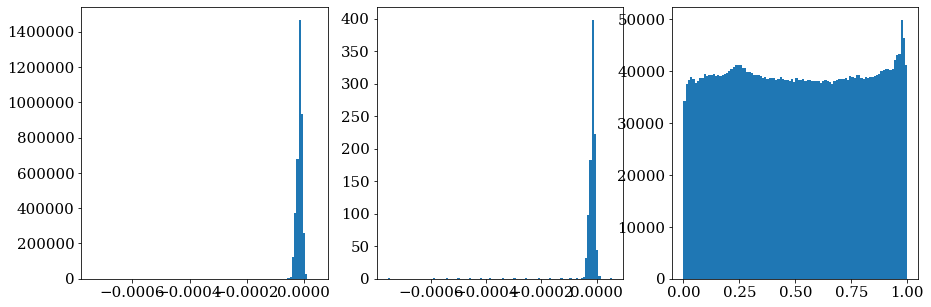

In [134]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(var0[:,ilev,:,:].values.flatten(),bins=100);
ax[1].hist(PERC_array[:,i0[var[:-4]]+ilev],bins=100);
ax[2].hist(output_percentile[:,ilev,:,:].values.flatten(),bins=100);